# ODE System and Analytical Solutions

$$
\begin{cases}
\frac{dy_1}{dx} = \frac{\cos(x) - \sin(x)}{y_2}, & \quad y_1(0) = 0 \\[2ex]
\frac{dy_2}{dx} = y_1 y_2 + e^x - \sin(x), & \quad y_2(0) = 1
\end{cases}
$$

**Analytical Solution:**
$$
\begin{cases}
y_1(x) = \frac{sin(x)}{e^{x}} \\
y_2(x) = e^{x}
\end{cases}
$$

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Lambda

In [36]:
def custom_output(x):
    y1 = x[:, :1]
    y2 = tf.exp(x[:, 1:2])
    return tf.concat([y1, y2], axis=1)

model = tf.keras.Sequential([
    Input((1,)),
    Dense(32, activation='tanh'),
    Dense(2),
    Lambda(custom_output)
])

In [37]:
def pinn_loss(x, model):
    x = x.reshape(-1, 1)
    x_tf = tf.constant(x, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_tf)
        y_pred = model(x_tf)
        y1 = y_pred[:, 0:1]
        y2 = y_pred[:, 1:2]

    dy1_dx = tape.gradient(y1, x_tf)
    dy2_dx = tape.gradient(y2, x_tf)
    del tape

    f1 = dy1_dx - (tf.cos(x_tf) - tf.sin(x_tf)) / y2
    f2 = dy2_dx - (y1 * y2 + tf.exp(x_tf) - tf.sin(x_tf))

    y0_pred = model(tf.constant([[0.0]], dtype=tf.float32))
    ic1 = y0_pred[0, 0] - 0.0
    ic2 = y0_pred[0, 1] - 1.0

    loss = tf.reduce_mean(tf.square(f1)) + tf.reduce_mean(tf.square(f2)) \
           + tf.square(ic1) + tf.square(ic2)
    return loss


In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
x_train = np.linspace(0, 1, 100).reshape(-1, 1)
loss_history = []

for i in range(3000):
    with tf.GradientTape() as tape:
        loss = pinn_loss(x_train, model)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_history.append(loss.numpy())
    if i % 500 == 0:
        print(f"Step {i}, Loss: {loss.numpy()}")


Step 0, Loss: 1.8403371572494507
Step 500, Loss: 0.10528146475553513
Step 1000, Loss: 0.022680656984448433
Step 1500, Loss: 0.0034313672222197056
Step 2000, Loss: 0.0022379346191883087
Step 2500, Loss: 0.0013390349922701716


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


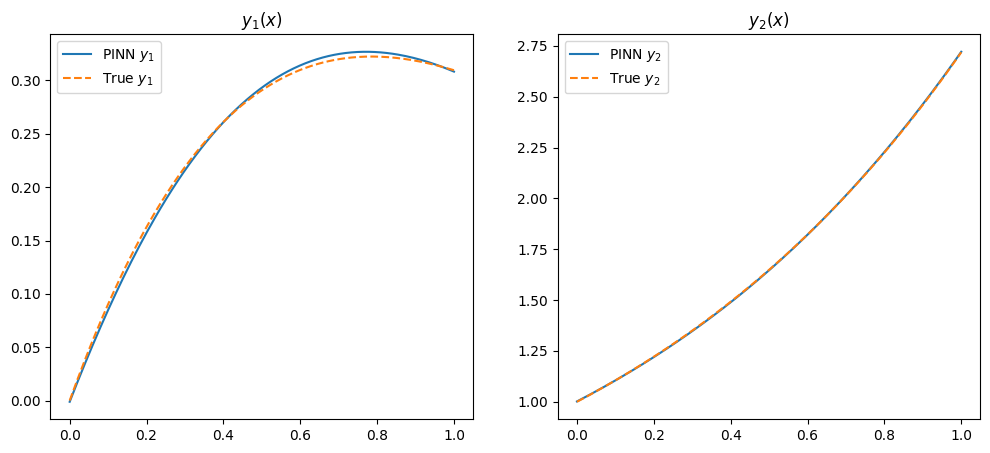

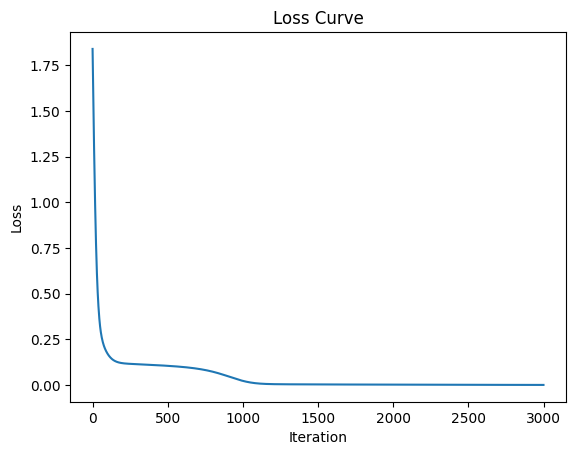

In [39]:
x_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_pred = model.predict(x_test)
y1_pred = y_pred[:, 0]
y2_pred = y_pred[:, 1]

y1_true = np.sin(x_test).flatten() / np.exp(x_test).flatten()
y2_true = np.exp(x_test).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x_test, y1_pred, label='PINN $y_1$')
plt.plot(x_test, y1_true, '--', label='True $y_1$')
plt.legend()
plt.title('$y_1(x)$')

plt.subplot(1,2,2)
plt.plot(x_test, y2_pred, label='PINN $y_2$')
plt.plot(x_test, y2_true, '--', label='True $y_2$')
plt.legend()
plt.title('$y_2(x)$')

plt.show()

plt.figure()
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()
